In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
# Import packages
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np


# Dates
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from sklearn.metrics import mean_squared_error

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
# plt.rcParams['font.sans-serif']
import matplotlib
print(matplotlib.__file__)

/Users/Dennis/anaconda3/lib/python3.11/site-packages/matplotlib/__init__.py


<Axes: >

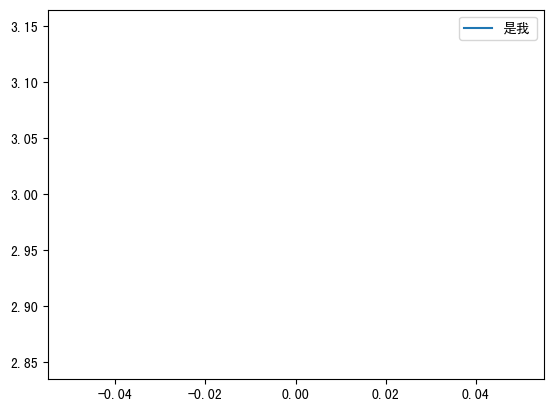

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

pd.DataFrame({'是我':3 },index=[0]).plot()


In [26]:
main_metric = 'TOT_SALES'
breakdown_metrics = ['PRICE' , 'PROD_QTY']
analytics_unit = 'STORE_NBR'
time_var = 'YEAR_MONTH'

In [27]:
df = pd.read_csv('QVI_data.csv')
df['PRICE'] = df['TOT_SALES'] / df['PROD_QTY']
df['YEAR_MONTH'] = pd.to_datetime(df['DATE']).dt.strftime('%Y-%m')
df['test_site'] = df['STORE_NBR'].apply(lambda x: 'test' if x in [77,86,88] else 'control')

store_df=df.groupby(['STORE_NBR','BRAND','DATE']).agg({'TOT_SALES':'sum','LYLTY_CARD_NBR':'nunique','TXN_ID':'nunique','PROD_QTY':'sum'})

store_df['PRICE']=store_df['TOT_SALES']/store_df['PROD_QTY']
store_df['CHIP_PER_TXN']=store_df['PROD_QTY']/store_df['TXN_ID']
store_df=store_df.rename(columns={'LYLTY_CARD_NBR':'CUSTOMERS'})
store_df['TXN_PER_CUST']=store_df['TXN_ID']/store_df['CUSTOMERS']
store_df.drop(['TXN_ID'],axis=1,inplace=True)
store_df.reset_index(inplace=True)
store_df['YEAR_MONTH'] = pd.to_datetime(store_df['DATE']).dt.strftime('%Y-%m')
store_df = store_df.groupby(['STORE_NBR','BRAND','YEAR_MONTH']).agg({'TOT_SALES':'sum','CUSTOMERS':'sum','PROD_QTY':'sum','PRICE':'mean','CHIP_PER_TXN':'mean','TXN_PER_CUST':'mean'}).reset_index()
store_df['test_site'] = store_df['STORE_NBR'].apply(lambda x: 'test' if x in [77,86,88] else 'control')
store_df

,STORE_NBR,BRAND,YEAR_MONTH,TOT_SALES,CUSTOMERS,PROD_QTY,PRICE,CHIP_PER_TXN,TXN_PER_CUST,test_site
0,1,BURGER,2018-07,2.3,1,1,2.3,1.0,1.0,control
1,1,BURGER,2018-08,2.3,1,1,2.3,1.0,1.0,control
2,1,BURGER,2018-09,2.3,1,1,2.3,1.0,1.0,control
3,1,BURGER,2018-11,2.3,1,1,2.3,1.0,1.0,control
4,1,BURGER,2019-02,2.3,1,1,2.3,1.0,1.0,control
...,...,...,...,...,...,...,...,...,...,...
46325,272,TYRRELLS,2018-10,8.4,1,2,4.2,2.0,1.0,control
46326,272,TYRRELLS,2018-12,33.6,4,8,4.2,2.0,1.0,control
46327,272,TYRRELLS,2019-01,16.8,2,4,4.2,2.0,1.0,control
46328,272,TYRRELLS,2019-03,8.4,1,2,4.2,2.0,1.0,control


In [28]:
def plot_uplift_with_scatter(uplift_df, y, x):
    # Calculate the area (impact) of the bars
    uplift_df = uplift_df.sort_values(by=x, ascending=True)
    # Create a boolean mask to separate positive and negative uplift values
    positive_uplift_mask = uplift_df[x] > 0

    # Set colors for bars based on the uplift direction
    colors = ['#F79E1B' if uplift else '#EB001B' for uplift in positive_uplift_mask]

    # Create the bar plot
    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    plt.subplot(2, 1, 1)
    plt.barh(uplift_df[y], uplift_df[x], color=colors)

    # Add a vertical line at x=0
    plt.axhline(0, color='gray', linestyle='--')

    # Customize the bar plot
    plt.xlabel(y)
    plt.ylabel(f"{x} (Impact)")
    plt.title("Uplift Bar Plot")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Create the scatter plot
    plt.subplot(2, 1, 2)
    plt.scatter(uplift_df["impact"], uplift_df["size"] , color =  colors)

    # Customize the scatter plot
    plt.xlabel("Impact")
    plt.ylabel("Size")
    plt.title("Scatter Plot")
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # add text
    for index, row in uplift_df.iterrows():
        plt.text(row["impact"], row["size"], row[y], ha='center', va='center')

    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()



class APT_Site_Assistant:
    
    def __init__(self) -> None:

        self.main_metric = None
        self.breakdown_metrics = []
        self.matching_criterias = []
        self.category_hierarchy = []
        self.attributes = []
        
        
        self.df = None 
        self.test_var = ''
        self.time_var = ''
        self.analytic_unit_var = ''
        
        self.site_scores = None
        
        self.criteria_weights = []
        self.financial_pattern = []
        self.slope_pattern = []
        
        self.uplift_df = None
        
        self.plot_process = True
        self.select_test_sql_query =  ''
        self.rank_num = 5
        
    
    
    
    def setup_mastercard_color_style(self):
        mc_colors = ['#EB001B' , '#FF5F00', '#F79E1B' , '#231F20']
        mpl.rcParams['axes.prop_cycle'] =  mpl.cycler(color = mc_colors)
        # make sns follow the color style
        sns.set_palette(mc_colors)
    
    def setup_analysis_data(self,analytic_unit_var, time_var, test_var, df):
        self.analytic_unit_var = analytic_unit_var
        self.time_var = time_var
        self.test_var = test_var
        self.df = df
        
    def setup_time_frame(self, baseline_period : list, analysis_period : list):
        self.baseline_period = baseline_period
        self.analysis_period = analysis_period
        
    
    def setup_metric_structure(self, main_metric:str, breakdown_metrics:list):
        self.main_metric = main_metric
        self.breakdown_metrics =  breakdown_metrics
        
    
    def setup_category_structure(self, category_hierarchy:list):
        self.category_hierarchy = category_hierarchy
    
    def setup_site_matching_criterias(self,matching_criterias:list , criteria_weights:list):
        self.matching_criterias = matching_criterias 
        self.criteria_weights = criteria_weights
        

    def setup_sql_query(self, select_test_sql_query):
        self.select_test_sql_query = select_test_sql_query
        
    def setup_attributes(self,attributes:list):
        self.attributes = attributes

    def calculate_correlation(self, criteria , trial_site):
        calc_corr_table = pd.DataFrame({'Store1': [], 'Store2': [], 'corr_measure': []})
        x = self.df.loc[self.df[self.analytic_unit_var] == trial_site, criteria]
        x.reset_index(drop=True, inplace=True)
        store_numbers = self.df[self.analytic_unit_var].unique()
        for i in store_numbers:
            y = self.df.loc[self.df[self.analytic_unit_var] == i, criteria]
            y.reset_index(drop=True, inplace=True)
            calc_corr_table = calc_corr_table.append({'Store1': trial_site, 'Store2': i, 'corr_measure': y.corr(x)}, ignore_index=True)
        return calc_corr_table

    def calculate_magnitude_distance(self, criteria, trial_site):
        calc_dist_table = pd.DataFrame({'Store1': [], 'Store2': [], 'Magnitude': []})
        x = self.df.loc[self.df[self.analytic_unit_var] == trial_site, criteria]
        x.reset_index(drop=True, inplace=True)
        store_numbers = self.df[self.analytic_unit_var].unique()
        for i in store_numbers:
            y = self.df.loc[self.df[self.analytic_unit_var] == i, criteria]
            y.reset_index(drop=True, inplace=True)
            z = abs(x - y)
            A = np.mean(1 - (z - min(z)) / (max(z) - min(z)))
            calc_dist_table = calc_dist_table.append({'Store1': trial_site, 'Store2': i, 'Magnitude': A}, ignore_index=True)
        return calc_dist_table
    
    def calculate_site_score(self,criteria, trial_site , weights = [0.5,0.5]):
        score_criteria_name = 'score_{}'.format(criteria)
        corr_criteria = self.calculate_correlation(criteria , trial_site)
        magnitude_criteria = self.calculate_magnitude_distance(criteria, trial_site)
        score_table = pd.merge(corr_criteria, magnitude_criteria, on=['Store1', 'Store2'])
        score_table[score_criteria_name] = weights[0] * score_table['corr_measure'] + weights[1] * score_table['Magnitude']
        score_table.set_index(['Store1', 'Store2'], inplace = True)
        return score_table[score_criteria_name]
    
    def get_similar_site(self, trial_site, rank_num = 5):
        score_control = []
        weights = self.criteria_weights
        for criteria in self.matching_criterias:
            score_control.append(self.calculate_site_score(criteria, trial_site))
        score_control_df = pd.concat(score_control, axis=1)
        if weights == []:
            weights = [1/len(self.matching_criterias)] * len(self.matching_criterias)
        score_control_df['final_control_score'] = score_control_df.apply(lambda x: sum(x * weights), axis=1)
        score_control_df = score_control_df.sort_values(by='final_control_score', ascending=False).head(rank_num)
        return score_control_df
    
    def check_lift_distribution(self, trial_site, control_sites:list, metric:str , pass_df = None):
        
        trial_control_group = [trial_site] + control_sites
        if pass_df is None:
            keep_df = self.df[self.df[self.analytic_unit_var].isin(trial_control_group)]
        else:
            keep_df = pass_df[pass_df[self.analytic_unit_var].isin(trial_control_group)]

        if self.plot_process == True:
            display(metric)
            display(keep_df.head(5))
            display(trial_site)
            display(control_sites)
            self.plot_tnl_with_uplift_chart(metric, keep_df, trial_site, control_sites)
        
        return None 
        
    def plot_tnl_with_uplift_chart(self, metric, keep_df, trial_site, control_sites):
        fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))

        # Subplot 1: Distribution of the metric by analytic_unit_var
        sns.lineplot(x=self.time_var, y=metric, data=keep_df, hue=self.analytic_unit_var, ci=True, ax=ax1)
        ax1.axvspan(self.baseline_period[0], self.baseline_period[1], color='grey', alpha=0.2)
        ax1.axvspan(self.analysis_period[0], self.analysis_period[1], color='orange', alpha=0.2)
        ax1.text(self.baseline_period[0], keep_df[metric].max(), 'Baseline Period', fontsize=12)
        ax1.text(self.analysis_period[0], keep_df[metric].max(), 'Analysis Period', fontsize=12)
        ax1.set_title('Distribution of {} by {}: Site = {}'.format(metric, self.analytic_unit_var, trial_site))

        # Subplot 2: Lift of the metric by analytic_unit_var
        lift_df = keep_df.pivot_table(index=self.time_var, columns=self.analytic_unit_var, values=metric)
        control_site = control_sites[0]
        lift_df['lift'] = (lift_df[trial_site] / lift_df[control_site]) - 1
        sns.lineplot(x=lift_df.index, y='lift', data=lift_df, color='black', ax=ax2)
        ax2.axhline(y=0, color='black', linestyle='--')
        ax2.axvspan(self.baseline_period[0], self.baseline_period[1], color='grey', alpha=0.2)
        ax2.axvspan(self.analysis_period[0], self.analysis_period[1], color='orange', alpha=0.2)
        ax2.set_title('Lift of {} by {}: Site = {}'.format(metric, self.analytic_unit_var, trial_site))

        plt.tight_layout()  # To prevent overlapping of titles and axes labels
        plt.show()

        return None

    
    def do_site_control_find_similar(self, trial_site, df = None, rank_num = 5, metric=''):
        if metric == '':
            metric = self.main_metric
        if df is None:
            df = self.df
        
        similar_site = self.get_similar_site(trial_site, rank_num)
        all_control_sites = similar_site.index.get_level_values(1).tolist()
        control_test_df = df[df[self.analytic_unit_var].isin(all_control_sites + [trial_site])]
        ts_data = pd.pivot_table(control_test_df, index=self.time_var, columns=self.analytic_unit_var, values=metric)
        
        y = ts_data[trial_site]
        X = ts_data.drop(trial_site, axis=1).fillna(0)
        if self.financial_pattern is not []:
            X = self.fix_criteria_seasonality(X)
        baseline_y = y.loc[self.baseline_period[0]:self.baseline_period[1]]
        baseline_X = X.loc[self.baseline_period[0]:self.baseline_period[1]]
        model = sm.OLS(baseline_y, baseline_X)
        fit_y = model.fit().predict(X)    
        uplift_df = pd.DataFrame({'trial': y, 'control': fit_y})
        uplift_df['uplift'] = (uplift_df['trial'] / uplift_df['control']) - 1 
        uplift_df['impact'] = uplift_df['trial'] - uplift_df['control']
        # keep only analysis period
        uplift_df = uplift_df.loc[self.analysis_period[0]:self.analysis_period[1]].reset_index()
        uplift_df[analytics_unit] = trial_site
        fitting_trial_control_df = pd.DataFrame({'trial': y, 'control': fit_y}).unstack().reset_index()
        fitting_trial_control_df.columns = [self.analytic_unit_var, self.time_var, metric]
        trial_name = 'trial : {}'.format(trial_site)
        fitting_trial_control_df[analytics_unit].replace('trial' , trial_name, inplace=True)
        self.check_lift_distribution(trial_name, ['control'],metric, fitting_trial_control_df)
        return fitting_trial_control_df, uplift_df
        
    def conduct_site_control(self, df = None, rank_num = 5, metric='' , save_as_uplift_df = True, plot=True):
        if metric == '':
            metric = self.main_metric
        if df is None:
            df = self.df
        
        total_trial_sites = df.query(self.select_test_sql_query)[self.analytic_unit_var].unique()
        weights = self.criteria_weights
        total_uplift_df = []
        total_fitting_trial_control_df = []
        for trial_site in total_trial_sites:
            fitting_trial_control_df, uplift_df = self.do_site_control_find_similar(trial_site = trial_site, df = df, rank_num = rank_num, metric=metric)
            total_uplift_df.append(uplift_df)
            total_fitting_trial_control_df.append(fitting_trial_control_df)
        
        
        total_fitting_trial_control_df = pd.concat(total_fitting_trial_control_df)
        total_uplift_df = pd.concat(total_uplift_df)
        
        total_fitting_trial_control_df[self.test_var] = total_fitting_trial_control_df[self.analytic_unit_var]
        total_fitting_trial_control_df[self.analytic_unit_var] = total_fitting_trial_control_df[self.analytic_unit_var].apply(lambda x: 'control' if 'control' in x else 'test')
        total_fitting_trial_control_df.rename({'metric':metric},axis=1 , inplace=True)
        total_fitting_trial_control_df = total_fitting_trial_control_df.groupby([self.analytic_unit_var , self.time_var ]).agg({metric:'sum'}).reset_index()
        if plot:
            self.plot_tnl_with_uplift_chart(metric, total_fitting_trial_control_df, 'test', ['control'])
        if save_as_uplift_df:
            self.uplift_df = total_uplift_df
        return total_fitting_trial_control_df,total_uplift_df
    
    def add_criteria_seasonality(self, seasonality_period:list):
        
        self.financial_pattern.append(seasonality_period)
        return None
    
    
    
    
    def fix_criteria_seasonality(self, X ):
        ori_X = X.copy()
        for seasonality_period in self.financial_pattern:
            X_feat = ori_X.mean(axis=1)
            X_feat.loc[seasonality_period[0]:seasonality_period[1]] = ori_X.loc[seasonality_period[0]:seasonality_period[1]].mean(axis=1)
            X_feat = (X_feat - X_feat.shift(1)).fillna(X_feat.mean())
            X = pd.concat([X, X_feat], axis=1)
        return X
        
    def run_metric_tree(self):
        self.plot_process = False
        reports = []
        metric_tree = [self.main_metric] + self.breakdown_metrics
        for metric in metric_tree:
            total_fitting_trial_control_df,total_uplift_df = self.conduct_site_control(self.rank_num , metric , save_as_uplift_df=False)
            uplift_summary = self.calculate_total_uplift_impact(total_uplift_df)
            reports.append(uplift_summary)
        
        for metric, uplift_summary in zip(metric_tree, reports):
            print('-'*20)
            print('#'*20 + ' Metric : {} '.format(metric) + '#'*20)
            display(uplift_summary)
            print('-'*20)
        self.plot_process = True
        return None 

    def calculate_total_uplift_impact(self, total_uplift_df):
        overall_uplift = (total_uplift_df['trial'].sum() /  total_uplift_df['control'].sum()) - 1
        overall_impact = total_uplift_df['trial'].sum() - total_uplift_df['control'].sum()
        uplift_summary = pd.DataFrame({'overall_uplift': [overall_uplift], 'overall_impact': [overall_impact]})
        return uplift_summary
            
    def run_categorical_driver(self , level = 0):
        category_report = []
        self.plot_process = False
        for category in self.df[self.category_hierarchy[level]].unique():
            category_df = self.df[self.df[self.category_hierarchy[level]] == category]
            this_category_fit_df, this_category_uplift_df = self.conduct_site_control(category_df , plot= False)
            this_category_uplift_df = pd.DataFrame(this_category_uplift_df.mean()).T
            this_category_uplift_df['category'] = category
            this_category_uplift_df['size'] = self.df[self.df[self.category_hierarchy[level]] == category].shape[0]
            this_category_fit_df
            
            category_report.append(this_category_uplift_df)
        self.plot_process = True
        category_report = pd.concat(category_report)
        plot_uplift_with_scatter(category_report, y='category', x='uplift')
        return category_report

        
            
            

77

,STORE_NBR,BRAND,YEAR_MONTH,TOT_SALES,CUSTOMERS,PROD_QTY,PRICE,CHIP_PER_TXN,TXN_PER_CUST,test_site
0,1,BURGER,2018-07,2.3,1,1,2.3,1.0,1.0,control
1,1,BURGER,2018-08,2.3,1,1,2.3,1.0,1.0,control
2,1,BURGER,2018-09,2.3,1,1,2.3,1.0,1.0,control
3,1,BURGER,2018-11,2.3,1,1,2.3,1.0,1.0,control
4,1,BURGER,2019-02,2.3,1,1,2.3,1.0,1.0,control
...,...,...,...,...,...,...,...,...,...,...
46325,272,TYRRELLS,2018-10,8.4,1,2,4.2,2.0,1.0,control
46326,272,TYRRELLS,2018-12,33.6,4,8,4.2,2.0,1.0,control
46327,272,TYRRELLS,2019-01,16.8,2,4,4.2,2.0,1.0,control
46328,272,TYRRELLS,2019-03,8.4,1,2,4.2,2.0,1.0,control


'TOT_SALES'

,STORE_NBR,YEAR_MONTH,TOT_SALES
0,trial : 77,2018-07,18.550000
1,trial : 77,2018-08,15.968750
2,trial : 77,2018-09,14.075000
3,trial : 77,2018-10,14.607143
4,trial : 77,2018-11,13.627778


'trial : 77'

['control']

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

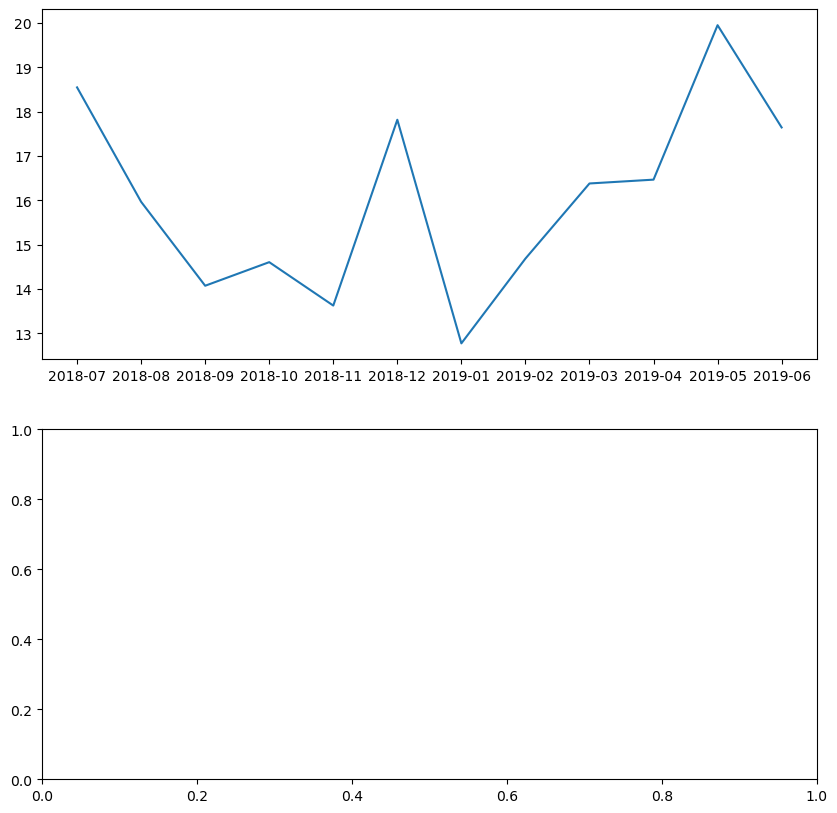

In [29]:
apt_helper.plot_process = True
total_fitting_trial_control_df, total_uplift_df = apt_helper.conduct_site_control()

In [18]:
apt_helper = APT_Site_Assistant()
# apt_helper.setup_mastercard_color_style()

"""setup t&l"""
apt_helper.setup_analysis_data(analytics_unit ,time_var , 'test_site', store_df )
apt_helper.setup_metric_structure(main_metric,breakdown_metrics)
apt_helper.setup_category_structure(['BRAND'])
apt_helper.setup_site_matching_criterias(['TOT_SALES' , 'CUSTOMERS'] , [0.5,0.5])
apt_helper.setup_time_frame(['2018-07' , '2019-01'] , ['2019-02' , '2019-04'])
apt_helper.setup_sql_query('test_site == "test"')

"""control strategy"""
apt_helper.add_criteria_seasonality(['2018-07' , '2019-01'])
# apt_helper.plot_process = False

"""test & learn"""

apt_helper.run_metric_tree()
# category_report = apt_helper.run_categorical_driver()

AttributeError: 'int' object has no attribute 'query'

In [ ]:
"""dev"""

# fitting_trial_control_df, uplift_df = apt_helper.do_site_control_find_similar(77,5)
# apt_helper.get_similar_site(77,5)
# apt_helper.check_lift_distribution(77,[233,35,41] , 'TOT_SALES')

In [13]:
category_report

,trial,control,uplift,impact,STORE_NBR,category,size
0,6.900000,NaN,NaN,NaN,81.500000,BURGER,985
0,17.640000,34.804507,-1.064883,-12.404507,81.500000,CCS,1547
0,7.375000,12.221459,-1.588401,-4.421459,81.500000,CHEETOS,1343
0,20.175000,38.120107,-0.952804,-13.220107,83.666667,CHEEZELS,2114
0,55.914286,33.267888,3.909572,28.798778,83.666667,COBS,2577
0,102.622222,132.947421,-0.214000,-30.325199,83.666667,DORITOS,2943
0,10.000000,NaN,NaN,NaN,81.500000,FRENCH,930
0,26.088889,40.010357,-0.889836,-16.010357,83.666667,GRNWVES,2556
0,44.777778,90.147578,-0.470760,-29.314245,83.666667,INFUZIONS,2770
0,186.555556,256.217257,-0.515800,-69.661702,83.666667,KETTLE,2983
